In [282]:
import sys
import os

# Get the absolute path to the notebook's directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
# Add the project root (parent of notebook dir) to Python path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

In [283]:
import matplotlib.pyplot as plt

In [284]:

from data.dataset import TUMTraf


In [285]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [286]:
import glob, re

In [287]:


from pathlib import Path

data_dir_val = Path(project_root) / "data" / "TUMTraf_Event_Dataset" / "val"

rgb_val_data = str(data_dir_val / "images" / "rgb")
eb_val_data = str(data_dir_val / "images" / "eb_transformed")

rgb_val_label = str(data_dir_val / "OPENLabel_labels_rgb")
eb_val_label = str(data_dir_val / "OPENLabel_labels_eb")

tumtraf_rbg_val_dataset = TUMTraf(img_dir=rgb_val_data, label_dir=rgb_val_label)
tumtraf_eb_val_dataset = TUMTraf(img_dir=eb_val_data, label_dir=eb_val_label)

In [288]:
index = 0

for i, (img, label) in enumerate(tumtraf_eb_val_dataset):
    if '20231114-082434.166224' == label['id']: 
        index = i
        print (i)

555


In [289]:

print ("for rgb")
img, label = tumtraf_rbg_val_dataset[index]
print(img.shape)

print ("for eb")
img_eb, label_eb = tumtraf_eb_val_dataset[index]
print(img_eb.shape)

for rgb
torch.Size([3, 480, 640])
for eb
torch.Size([1, 480, 640])


label for rgb

In [290]:
label

{'id': '20231114-082434.166224',
 'data': {'openlabel': {'metadata': {'schema_version': '1.0.0'},
   'coordinate_systems': 169,
   'frames': {'169': {'objects': {'0': {'object_data': {'name': 'CAR_0',
        'type': 'CAR',
        'bbox': [{'name': 'full_bbox',
          'val': [257, 24, 25, 18],
          'attributes': {'text': [{'name': 'sensor_id',
             'val': 'default_cam'}]}}]}},
      '1': {'object_data': {'name': 'PEDESTRIAN_1',
        'type': 'PEDESTRIAN',
        'bbox': [{'name': 'full_bbox',
          'val': [573, 240, 27, 65],
          'attributes': {'text': [{'name': 'sensor_id',
             'val': 'default_cam'}]}}]}},
      '2': {'object_data': {'name': 'CAR_2',
        'type': 'CAR',
        'bbox': [{'name': 'full_bbox',
          'val': [601, 430, 75, 97],
          'attributes': {'text': [{'name': 'sensor_id',
             'val': 'default_cam'}]}}]}},
      '3': {'object_data': {'name': 'CAR_3',
        'type': 'CAR',
        'bbox': [{'name': 'full_bbox'

label for eb

In [291]:
label_eb

{'id': '20231114-082434.166224',
 'data': {'openlabel': {'metadata': {'schema_version': '1.0.0'},
   'coordinate_systems': 169,
   'frames': {'169': {'objects': {'0': {'object_data': {'name': 'PEDESTRIAN_0',
        'type': 'PEDESTRIAN',
        'bbox': [{'name': 'full_bbox',
          'val': [568, 167, 38, 58],
          'attributes': {'text': [{'name': 'sensor_id',
             'val': 'default_cam'}]}}]}},
      '1': {'object_data': {'name': 'PEDESTRIAN_1',
        'type': 'PEDESTRIAN',
        'bbox': [{'name': 'full_bbox',
          'val': [574, 241, 46, 87],
          'attributes': {'text': [{'name': 'sensor_id',
             'val': 'default_cam'}]}}]}},
      '2': {'object_data': {'name': 'CAR_2',
        'type': 'CAR',
        'bbox': [{'name': 'full_bbox',
          'val': [258, 24, 46, 39],
          'attributes': {'text': [{'name': 'sensor_id',
             'val': 'default_cam'}]}}]}},
      '3': {'object_data': {'name': 'TRUCK_3',
        'type': 'TRUCK',
        'bbox': [{'

rgb image

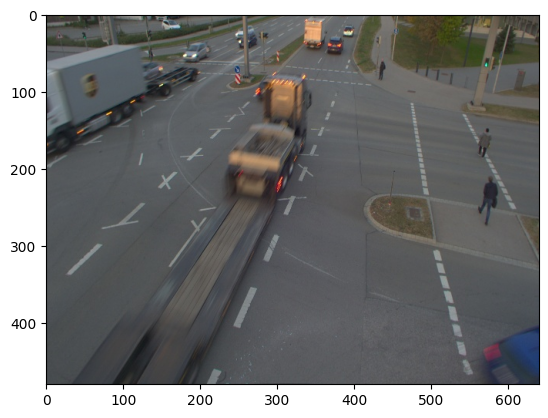

In [292]:


image =  img.numpy().transpose(1, 2, 0)
plt.imshow(image)

eb based image

: ,:460 ,115:600 ??

---vertical, horizontal

shape original (480, 640, 1)
shape after (460, 495, 1)


channel

shape original (480, 640, 1)
shape after (460, 495, 1)


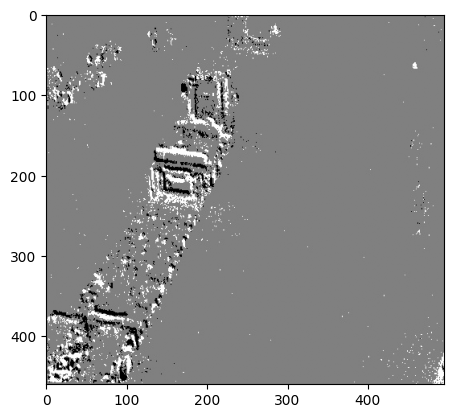

In [331]:
image_eb =  img_eb.numpy().transpose(1, 2, 0)

print ("shape original", image_eb.shape)

image_eb_cropped = img_eb[:,0:460, 115:610].numpy().transpose(1, 2, 0)

print ("shape after", image_eb_cropped.shape)
plt.imshow(image_eb_cropped, cmap='gray')


(480, 640, 1)


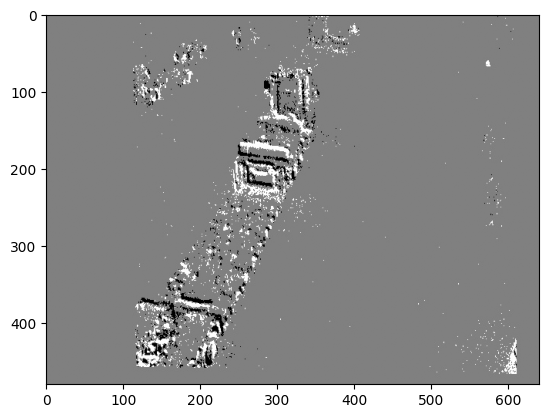

In [294]:
print( image_eb.shape)

plt.imshow(image_eb, cmap='gray')



draw the bounding boxes on top of the images

In [295]:
label['data']['openlabel']['frames'].keys()

dict_keys(['169'])

In [360]:


def draw_boxes_from_openlabel(image, label_data, thickness=2, transform=None):
    """
    Draw bounding boxes from OPENLabel format
    
    label_data: dict with structure {'data': {'openlabel': {'frames': {...}}}}
    bbox format in OPENLabel: [x_center, y_center, width, height]
    """
    image_copy = image.copy()
    
    # Extract frames from label data
    frames = label_data['data']['openlabel']['frames']
    
    # Get the first frame
    frame_key = list(frames.keys())[0]
    frame = frames[frame_key]
    
    # Extract objects
    objects = frame.get('objects', {})

    crop_y, crop_x = 0,0
    if transform:
        crop_x = transform.get("x")
        crop_y = transform.get("y")
    
    # Color map for different object types
    color_map = {
        'CAR': (0, 255, 0),      # Green
        'TRUCK': (0, 0, 255),    # Red
        'TRAILER': (255, 0, 0),  # Blue
        'BUS': (255, 255, 0),    # Cyan
        'MOTORCYCLE': (255, 0, 255)  # Magenta
    }
    
    # Draw each object
    for obj_id, obj_info in objects.items():
        object_data = obj_info['object_data']
        obj_type = object_data['type']
        obj_name = object_data['name']
        
        # Get bounding box - find full_bbox
        full_bbox = None
        if "bbox" in object_data and len(object_data["bbox"]) > 0:
            if len(object_data["bbox"]) == 1:
                full_bbox = object_data["bbox"][0]
            else:
                for bbox in object_data["bbox"]:
                    if bbox["name"] == "full_bbox":
                        full_bbox = bbox
                        break
        if full_bbox is not None:
            # bbox format: [x_center, y_center, width, height]
            x_center = int(full_bbox["val"][0]) - crop_x
            y_center = int(full_bbox["val"][1]) - crop_y
            width = int(full_bbox["val"][2]) 
            height = int(full_bbox["val"][3])
            
            # Convert to top-left and bottom-right coordinates
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2) 
            
            # Get color based on object type
            color = color_map.get(obj_type, (200, 200, 200))
            
            # Draw rectangle
            cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color, thickness)
            
            # Draw label
            label_text = f"{obj_name} ({obj_type})"
            cv2.putText(image_copy, label_text, (x_min, y_min - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return image_copy



In [352]:
transform = {
    "x": 115, "width": 600, "y": 0, "height": 460
}

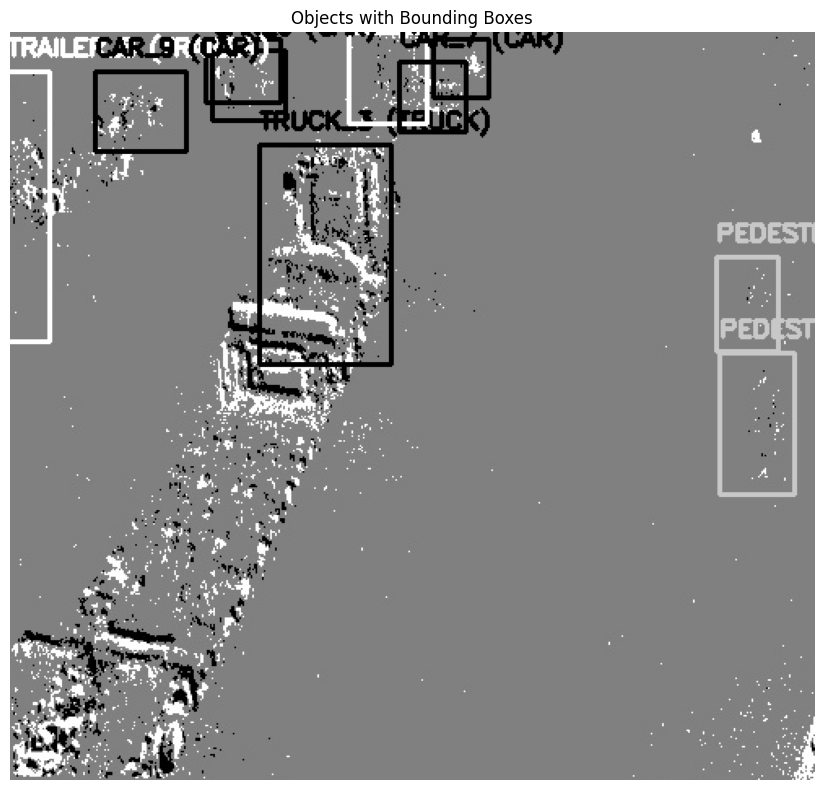

In [361]:
result = draw_boxes_from_openlabel(image_eb_cropped, label_eb, transform=transform) # BUG if you change to positional paremeters it breaks

plt.figure(figsize=(12, 8))
plt.imshow(result ,cmap='gray'  )
plt.title('Objects with Bounding Boxes')
plt.axis('off')
plt.tight_layout()
plt.show()

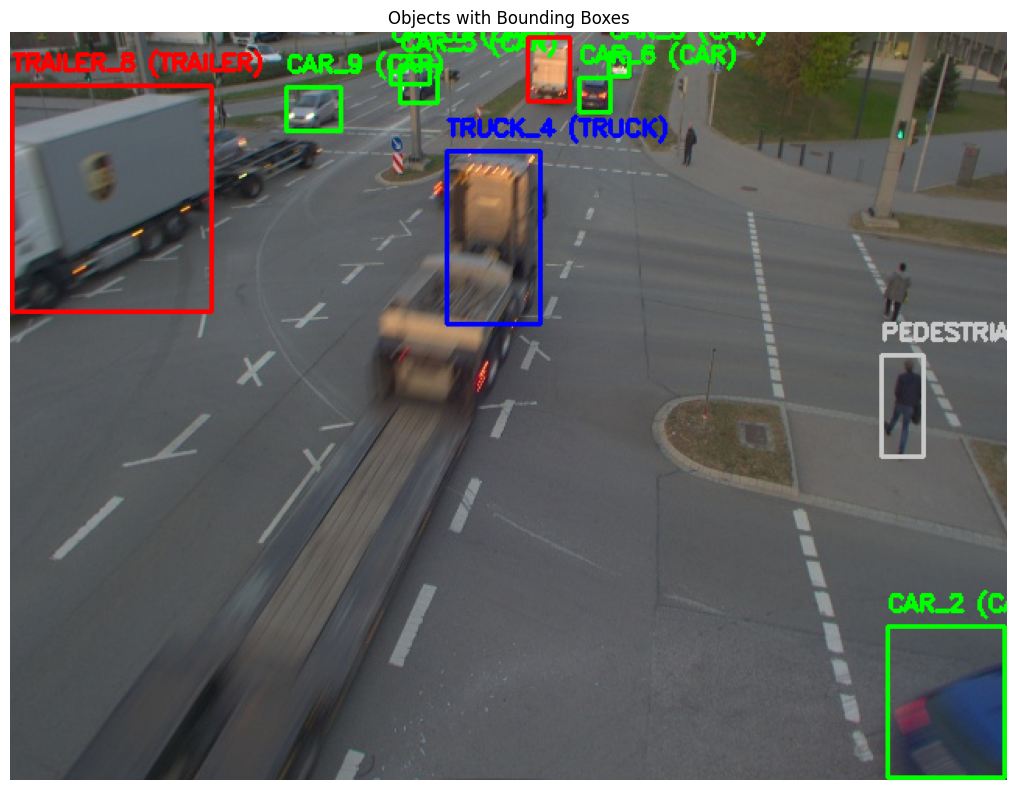

In [362]:
# Usage
result = draw_boxes_from_openlabel(image, label)

plt.figure(figsize=(12, 8))
plt.imshow(result)
plt.title('Objects with Bounding Boxes')
plt.axis('off')
plt.tight_layout()
plt.show()

In [322]:
image_eb.shape

(480, 640, 1)

undistort the event image 

In [323]:


calib_roi_rgb = np.loadtxt(project_root + "/data/TUMTraf_Event_Dataset/calibration/intrinsic/rgb_8mm_roi.txt")
rgb_roi_x, rgb_roi_y, rgb_roi_w, rgb_roi_h = calib_roi_rgb.astype(int)

calib_roi_eb = np.loadtxt(project_root + "/data/TUMTraf_Event_Dataset/calibration/intrinsic/eb_8mm_roi.txt")
eb_roi_x, eb_roi_y, eb_roi_w, eb_roi_h = calib_roi_eb.astype(int)




print("EB ROI:", f"x_offset={eb_roi_x}, y_offset={eb_roi_y}, width={eb_roi_w}, height={eb_roi_h}")

print("RGB ROI:", f"x_offset={rgb_roi_x}, y_offset={rgb_roi_y}, width={rgb_roi_w}, height={rgb_roi_h}")



EB ROI: x_offset=9, y_offset=13, width=612, height=451
RGB ROI: x_offset=12, y_offset=29, width=1894, height=1141


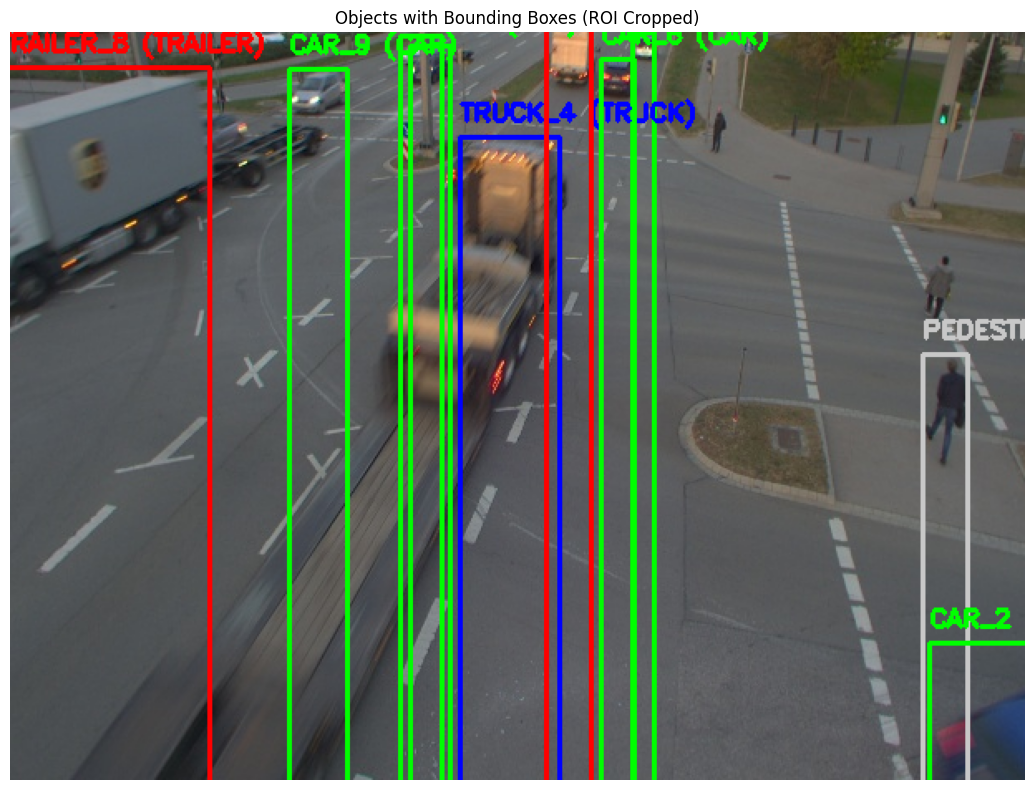

Original result shape: (480, 640, 3)
ROI cropped shape: (451, 612, 3)


In [324]:
# Crop the bounding box result using the EB ROI
result_roi_cropped = result[eb_roi_y:eb_roi_y+eb_roi_h, eb_roi_x:eb_roi_x+eb_roi_w]

# Plot the cropped result
plt.figure(figsize=(12, 8))
plt.imshow(result_roi_cropped, cmap='gray')
plt.title('Objects with Bounding Boxes (ROI Cropped)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Original result shape: {result.shape}")
print(f"ROI cropped shape: {result_roi_cropped.shape}")